In [23]:
import json
import pandas as pd
import numpy as np
import math
from statistics import NormalDist

import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

pd.options.display.float_format = '{:.2f}'.format

### SETUP 

In [24]:
def param_default():
    return {
        'dataset' : 'code_completion_random_cut_5k_30_512_tokens',
        #'dataset' : 'code_completion_docstring_random_cut_3.8k_30_150_tokens',
        #'dataset' : 'code_completion_docstring_signature_3.8k_30_150_tokens',
        #'dataset' : 'code_completion_docstring_5k_30_150_tokens',
        'global_ast_results': '/workspaces/code-rationales/data/global_ast_results/gpt',
        'global_taxonomy_results': '/workspaces/code-rationales/data/global_taxonomy_results/gpt',
        'quantitative_results' : '/workspaces/code-rationales/data/quantitative_results',
        'groupings' : '/workspaces/code-rationales/data/groupings', 
        'num_experiments' : 30, 
        'bootstrapping_size': 500 ## question.. should be 500, change name
    }
params = param_default()

### Taxonomy Classification

In [25]:
def global_groups() -> dict:
    return {
        'sc_semantic': ['exceptions', 'oop', 'asserts', 'types', 'conditionals', 'loops', 'bool', 'structural', 'statements', 'with'], 
        'sc_nl': ['identifier', 'comment', 'string'],
        'sc_not_semantic': ['punctuation', 'operators', 'indentation', 'functional', 'return', 'expression'], 
        'sc_errors' : ['errors'], 
        'nl_semantic': ['nl_verb', 'nl_noun', 'nl_pronoun', 'nl_adjetive'],
        'nl_not_semantic' : ['nl_adverb', 'nl_determiner', 'nl_preposition', 'nl_particle', 'nl_modal', 'nl_conjunction', 'nl_cardinal', 'nl_list'], 
        'unknown': ['unknown', 'nl_other'], 
        'excluded': ['excluded'], ### EXCLUDED CATEGORIES
    }

### Load Aggregation results

In [26]:
get_experiment_path =  lambda results_folder, dataset, exp: results_folder + '/' + dataset + '_exp_' + str(exp) +'.txt'


In [27]:
def get_experiments_results(results_folder):
    experiment_paths = [get_experiment_path(results_folder, params['dataset'], exp) for exp in range(params['num_experiments'])]
    experiment_global_results = []
    for experiment_path in experiment_paths:
        with open(experiment_path, 'r') as file:
            experiment_global_results.append(json.loads(file.read()))
    return experiment_global_results


### Dictionary Flatting

In [28]:
def flat_global_results(experiment_global_result: dict):
    flatten_results = { key: [] for key in experiment_global_result.keys() } ## There are 31 fixed categories
    for target_key, rationales in experiment_global_result.items():
        for rational_key, rational_values in rationales.items():
            flatten_results[rational_key] += rational_values
    return flatten_results

### Statistics

In [29]:
def bootstrapping( np_data, np_func, size ):
    """Create a bootstrap sample given data and a function
    For instance, a bootstrap sample of means, or mediands. 
    The bootstrap replicates are a long as the original size
    we can choose any observation more than once (resampling with replacement:np.random.choice)
    """
    
    #Cleaning NaNs
    #np_data_clean = np_data[ np.logical_not( np.isnan(np_data) ) ] 
    
    #The size of the bootstrap replicate is as big as size
    #Creating the boostrap replicates as long as the orignal data size
    #This strategy might work as imputation 
    bootstrap_repl = [ np_func( np.random.choice( np_data, size=len(np_data) ) ) for i in range( size ) ]
    
    #logging.info("Covariate: " + cov) #Empirical Mean
    #logging.info("Empirical Mean: " + str(np.mean(np_data_clean))) #Empirical Mean
    #logging.info("Bootstrapped Mean: " + str( np.mean(bootstrap_repl) ) ) #Bootstrapped Mean
    
    return np.array( bootstrap_repl )

In [30]:
def confidence_intervals_large_samples(data, confidence=0.95):
    """
    @confidence: confidence interval 
    @return: tuple (lowerbound, uperbound, h-value)
    """
    dist = NormalDist.from_samples( data )
    z = NormalDist().inv_cdf((1 + confidence) / 2.)
    h = dist.stdev * z / ((len(data) - 1) ** .5)
    return dist.mean - h, dist.mean + h, h

In [31]:
def boostrap_dictionary(dictionary: dict, size):
    boostrapped_dict = {}
    for key, values in dictionary.items():
        if values:
            boostrapped_dict[key] = bootstrapping(values, np.mean, size)
    return boostrapped_dict

### Data processing


In [32]:
def clean_results(global_results):
    def clean_dictonary(result_dict):
        clean_dict = result_dict.copy()
        for key, value in result_dict.items():
            if not value:
                clean_dict.pop(key)
        return clean_dict
    for key, value in global_results.items():
        global_results[key] = clean_dictonary(value)
    return clean_dictonary(global_results)

In [33]:
def get_experiments_dfs(experients_global_results):
    experiment_dfs = []
    for experiment in experients_global_results:
        experiment = flat_global_results(experiment)
        experiment = boostrap_dictionary(dictionary=experiment, size=params['bootstrapping_size'])
        experiment_dfs.append(pd.DataFrame(experiment))
    return experiment_dfs

In [34]:
### REDUCE EXPERIMENTS FOR HEATMAPS
def reduce_rationales_df(experients_global_results: dict, target_list: list, source_list: list):
    reduced_rationales_df = {target: {rational: [] for rational in source_list} for target in target_list}
    for experient_global_result in experients_global_results:
        target_dictionary = {key: value for key, value in experient_global_result.items() if key in target_list}
        for target_key in target_dictionary.keys():
            target_dictionary[target_key] = {key: np.median(bootstrapping(value, np.mean, 100)) # MEDIAN FOR EXPERIMENT RESULT
                                             for key, value in target_dictionary[target_key].items() if key in source_list}
            for rational_key in target_dictionary[target_key].keys():
                reduced_rationales_df[target_key][rational_key].append(target_dictionary[target_key][rational_key])
    for target_key in reduced_rationales_df.keys():
        reduced_rationales_df[target_key] = boostrap_dictionary(reduced_rationales_df[target_key], 100)
    return reduced_rationales_df         

### Grouping

In [35]:
def get_global_results_category_by_groups(experients_global_results: list):
    global_results_by_groups = [{} for _ in range(len(experients_global_results))]
    for exp_id, experiment_result in enumerate(experients_global_results):
        experiment = {category: {group: [] for group in global_groups().keys()} for category in experiment_result.keys()}
        for target_category in experiment_result.keys():
            for rational_category, rational_values in experiment_result[target_category].items():
                experiment[target_category][list(filter(lambda group: rational_category in global_groups()[group], global_groups().keys()))[0]] += rational_values
    for exp_id, experiment_result in enumerate(experients_global_results):
        global_results_by_groups[exp_id] = clean_results(experiment)
    return global_results_by_groups

In [36]:
def get_global_results_group_by_categories(experients_global_results: list):
    global_results_by_groups = [{} for _ in range(len(experients_global_results))]
    for exp_id, experiment_result in enumerate(experients_global_results):
        experiment = {group: {category: [] for category in experiment_result.keys()} for group in global_groups().keys()}
        for target_category in experiment_result.keys():
            for rational_category, rational_values in experiment_result[target_category].items():
                experiment[list(filter(lambda group: target_category in global_groups()[group], global_groups().keys()))[0]][rational_category] += rational_values
    for exp_id, experiment_result in enumerate(experients_global_results):
        global_results_by_groups[exp_id] = clean_results(experiment)
    return global_results_by_groups

In [37]:
def get_global_results_group_by_groups(experients_global_results: list):
    global_results_by_groups = [{} for _ in range(len(experients_global_results))]
    for exp_id, experiment_result in enumerate(experients_global_results):
        experiment = {group_target: {group_rational: [] for group_rational in global_groups().keys()} for group_target in global_groups().keys()}
        for target_category in experiment_result.keys():
            for rational_category, rational_values in experiment_result[target_category].items():
                experiment[list(filter(lambda group: target_category in global_groups()[group], global_groups().keys()))[0]][list(filter(lambda group: rational_category in global_groups()[group], global_groups().keys()))[0]] += rational_values
    for exp_id, experiment_result in enumerate(experients_global_results):
        global_results_by_groups[exp_id] = clean_results(experiment)
    return global_results_by_groups

### Visualization

In [38]:
def print_heatmap(
        experients_global_results: dict, 
        target_list: list, 
        source_list: list,
        ylabel: str, 
        xlabel: str,
        fig_size = (10,10), 
        font = 20, 
        vmax = 0.22
):
        reduced_rationales_global_results_df = pd.DataFrame(reduce_rationales_df(experients_global_results, target_list, source_list)).fillna(0)
        for column in reduced_rationales_global_results_df.columns:
                reduced_rationales_global_results_df[column] = reduced_rationales_global_results_df[column].apply(lambda value: np.median(value)) 

        cmap = LinearSegmentedColormap.from_list('custom_map', ['black','green'], N=128)
        #cmap = "YlGnBu"

        plt.rcParams.update({'font.size': font})
        ax = plt.axes()
        sns.set(rc = {'figure.figsize':fig_size})
        sns.heatmap(reduced_rationales_global_results_df, 
                    #cmap=cmap, 
                    vmin=0, vmax=vmax,
                    ax=ax)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show
        pass

### Analysis - Rational Concept - Countings

In [39]:
def create_frequencies_dataframe(experients_global_results: list):
    frequencies_df = pd.DataFrame(columns=experients_global_results[0].keys())
    for experiment_global_result in experients_global_results:
        rationales_results = flat_global_results(experiment_global_result)
        frequencies_df = frequencies_df.append({key: len(value) for key, value in rationales_results.items()}, ignore_index=True)
    frequencies_df = frequencies_df.fillna(0)   
    return frequencies_df


### Analysis - Rational Concept - Bootstrapping probability

In [40]:
# Function to fill NaN values with random chose from a specified array
def fill_nan_with_random_col(col):
    if col.isna().sum() == 0:
        return col
    random_values = np.random.choice(col[col.notna()].to_list(), col.isna().sum())
    col[col.isna()] = random_values
    return col

In [41]:
def create_bootstapped_dataframe(experients_global_results:list):
    bootstrapped_df = pd.DataFrame(columns=experients_global_results[0].keys())
    for experiment_global_result in experients_global_results:
        rationales_results = flat_global_results(experiment_global_result)
        rationales_results = boostrap_dictionary(dictionary=rationales_results, size=params['bootstrapping_size'])
        bootstrapped_df = bootstrapped_df.append({key: np.median(value) for key, value in rationales_results.items()}, ignore_index=True)
    return bootstrapped_df

### Calculate statistics and get results DF

In [42]:
### CREATE GROUP FREQUENCY RESULTS
def calculate_results(global_dataframe):
    results_df = pd.DataFrame(columns=['type', 'group', 'category', 'mean', 'median', 'std', 'ci'])
    for category in global_dataframe.columns:
        experiments_values = global_dataframe[category].tolist()
        try:
            group = [key for key, value in global_groups().items() if category in value][0] ## Mapping from taxonomy groups
        except Exception as e:
            print(e)
        results_df = results_df.append({
            'type': group.split('_')[0], 
            'group': group, 
            'category': category, 
            'median' : np.median(experiments_values),
            'mean' : np.mean(experiments_values), 
            'std' : np.std(experiments_values),
            'ci' : confidence_intervals_large_samples(experiments_values)
        }, ignore_index=True)
    return results_df.sort_values(by='median', ascending=False).reset_index(drop=True)

### Store Groupings

In [43]:
def store_groupings(global_results: list, name: str):
    with open(params['groupings'] + '/' + params['dataset'] + '_' + name + '.json', 'w') as output_file: 
        json.dump(global_results, output_file)

### Create Groupings

In [45]:
experiments_global_results = get_experiments_results(params['global_taxonomy_results'])
global_results_category_by_groups = get_global_results_category_by_groups(experiments_global_results)
global_results_group_by_categories = get_global_results_group_by_categories(experiments_global_results)
global_results_groups_by_groups = get_global_results_group_by_groups(experiments_global_results)

In [46]:
store_groupings(experiments_global_results, 'category_by_categories')
store_groupings(global_results_category_by_groups, 'category_by_groups')
store_groupings(global_results_group_by_categories, 'group_by_categories')
store_groupings(global_results_groups_by_groups, 'groups_by_groups')

### Frequency Analysis

In [22]:
global_frequencies_dataframe = create_frequencies_dataframe(experiments_global_results)
global_frequencies_dataframe

,punctuation,exceptions,oop,asserts,types,conditionals,loops,operators,bool,functional,...,nl_pronoun,nl_adverb,nl_adjetive,nl_determiner,nl_preposition,nl_particle,nl_modal,nl_conjunction,nl_cardinal,nl_other
0,151011,6328,15029,1047,93507,4814,1611,29827,1147,1184,...,3269,9885,33464,43299,47839,119,3163,15689,3246,8001
1,151012,7652,14474,1100,86532,4469,1980,29279,1651,3678,...,2996,8006,34210,41711,45923,214,2060,15249,3895,7367
2,138875,8402,13932,843,72250,3670,1786,30263,1444,1018,...,2503,7463,33155,38859,43700,194,2541,14196,4169,6107
3,155079,6574,14134,1007,95935,4384,1724,31709,1713,3440,...,3052,8844,34331,40924,46370,102,2149,15299,2462,7594
4,142609,7010,13827,917,72403,4861,1319,29629,1554,2385,...,3146,9521,32992,40028,46331,110,2512,14556,3579,6038
5,134947,7853,14389,736,78116,4096,1453,25804,1559,1697,...,2218,8423,30581,37005,41524,143,2237,13959,3706,6696
6,143787,4489,14507,1059,98220,5660,1783,31554,2059,1859,...,2648,8652,32564,41485,45965,159,2912,14426,3928,6949
7,146206,9012,14452,925,96552,4397,1929,30139,1221,2370,...,2781,8891,33498,38634,44277,150,2580,14405,2949,8980
8,146571,8182,14433,649,87423,4716,1704,28694,1827,1662,...,3475,9314,35203,43613,46831,370,2510,15787,4468,6908
9,138231,8879,13432,1125,96598,4656,1201,27815,2044,1032,...,3069,9038,32764,36497,43512,180,2038,13877,3639,7022


In [97]:
global_frequencies_dataframe_results = calculate_results(global_frequencies_dataframe).sort_values(by=['group','mean'],ascending=[True, False])
global_frequencies_dataframe_results

,type,group,category,mean,median,std,ci
1,excluded,excluded,excluded,610380.57,609823.50,26620.35,"(600526.295733206, 620234.8376001273, 9854.270..."
11,nl,nl_not_semantic,nl_preposition,44852.07,44577.50,1976.75,"(44120.3180932345, 45583.81524009883, 731.7485..."
13,nl,nl_not_semantic,nl_determiner,39995.23,39753.50,1956.13,"(39271.11624967507, 40719.35041699159, 724.117..."
18,nl,nl_not_semantic,nl_conjunction,14528.97,14421.00,541.43,"(14328.542920660882, 14729.390412672452, 200.4..."
20,nl,nl_not_semantic,nl_adverb,8615.57,8696.50,735.93,"(8343.1421488822, 8887.991184451135, 272.42451..."
24,nl,nl_not_semantic,nl_cardinal,3638.67,3691.00,543.52,"(3437.467137789605, 3839.866195543728, 201.199..."
27,nl,nl_not_semantic,nl_modal,2494.40,2511.00,281.09,"(2390.347482023927, 2598.452517976073, 104.052..."
32,nl,nl_not_semantic,nl_particle,179.37,174.00,75.37,"(151.4670097267355, 207.26632360659784, 27.899..."
3,nl,nl_semantic,nl_noun,360199.27,360676.50,13908.87,"(355050.5064228641, 365348.0269104692, 5148.76..."
12,nl,nl_semantic,nl_verb,43186.67,43206.00,1903.83,"(42481.910294155256, 43891.42303917807, 704.75..."


In [93]:
global_frequencies_dataframe_results.to_csv(params['quantitative_results'] + '/' + params['dataset'] + '_frequencies' + '.csv', index=False)

### Rationales Analysis

In [24]:
global_bootstrapped_dataframe = create_bootstapped_dataframe(experiments_global_results)
global_bootstrapped_dataframe = global_bootstrapped_dataframe.apply(fill_nan_with_random_col, axis = 0) ## Imputation values, picking a random value from non nan
global_bootstrapped_dataframe

,punctuation,exceptions,oop,asserts,types,conditionals,loops,operators,bool,functional,...,nl_pronoun,nl_adverb,nl_adjetive,nl_determiner,nl_preposition,nl_particle,nl_modal,nl_conjunction,nl_cardinal,nl_other
0,0.05,0.06,0.06,0.05,0.06,0.06,0.05,0.05,0.06,0.04,...,0.04,0.04,0.04,0.04,0.04,0.08,0.05,0.04,0.04,0.05
1,0.05,0.05,0.07,0.05,0.06,0.05,0.06,0.05,0.06,0.06,...,0.03,0.04,0.05,0.04,0.04,0.05,0.04,0.04,0.05,0.04
2,0.05,0.05,0.06,0.06,0.06,0.05,0.06,0.05,0.05,0.06,...,0.04,0.04,0.05,0.03,0.04,0.04,0.04,0.04,0.05,0.04
3,0.05,0.07,0.06,0.06,0.05,0.05,0.07,0.05,0.06,0.07,...,0.04,0.04,0.04,0.04,0.04,0.02,0.04,0.04,0.05,0.04
4,0.05,0.06,0.06,0.04,0.05,0.06,0.06,0.05,0.07,0.06,...,0.04,0.04,0.05,0.04,0.04,0.02,0.05,0.04,0.04,0.04
5,0.05,0.05,0.07,0.06,0.05,0.06,0.07,0.05,0.06,0.05,...,0.04,0.04,0.05,0.04,0.04,0.05,0.04,0.04,0.04,0.04
6,0.05,0.07,0.06,0.06,0.06,0.06,0.08,0.06,0.07,0.03,...,0.04,0.05,0.05,0.04,0.04,0.05,0.04,0.04,0.06,0.05
7,0.05,0.07,0.07,0.05,0.05,0.05,0.07,0.06,0.07,0.04,...,0.04,0.04,0.05,0.04,0.04,0.04,0.05,0.04,0.06,0.04
8,0.05,0.05,0.06,0.06,0.06,0.05,0.06,0.05,0.05,0.07,...,0.04,0.04,0.05,0.04,0.04,0.03,0.04,0.04,0.05,0.04
9,0.05,0.05,0.07,0.04,0.06,0.05,0.07,0.05,0.05,0.07,...,0.05,0.04,0.05,0.04,0.04,0.03,0.05,0.04,0.04,0.05


In [96]:
global_bootstrapped_dataframe_results = calculate_results(global_bootstrapped_dataframe).sort_values(by=['group','mean'],ascending=[True, False])
global_bootstrapped_dataframe_results

,type,group,category,mean,median,std,ci
14,excluded,excluded,excluded,0.05,0.05,0.00,"(0.05302496347415759, 0.054138714379153886, 0...."
20,nl,nl_not_semantic,nl_cardinal,0.05,0.05,0.01,"(0.04491111470433356, 0.049444905280753064, 0...."
24,nl,nl_not_semantic,nl_modal,0.05,0.05,0.01,"(0.044334601775087544, 0.04827866823680143, 0...."
27,nl,nl_not_semantic,nl_adverb,0.04,0.04,0.00,"(0.04156697500367607, 0.04369362053304109, 0.0..."
28,nl,nl_not_semantic,nl_conjunction,0.04,0.04,0.00,"(0.04092613784121376, 0.042131087618514605, 0...."
29,nl,nl_not_semantic,nl_preposition,0.04,0.04,0.00,"(0.04010635776720023, 0.040976268769833166, 0...."
31,nl,nl_not_semantic,nl_determiner,0.04,0.04,0.00,"(0.03596067373617118, 0.03688051741086726, 0.0..."
32,nl,nl_not_semantic,nl_particle,0.03,0.03,0.01,"(0.029683088988982764, 0.03905984109735002, 0...."
15,nl,nl_semantic,nl_noun,0.05,0.05,0.00,"(0.051740915536598944, 0.05277044392581029, 0...."
21,nl,nl_semantic,nl_adjetive,0.05,0.05,0.00,"(0.04666658708201556, 0.047906693777117586, 0...."


In [95]:
global_bootstrapped_dataframe_results.to_csv(params['quantitative_results'] + '/' + params['dataset'] + '_bootstrapped' + '.csv', index=False)

### Heatmaps

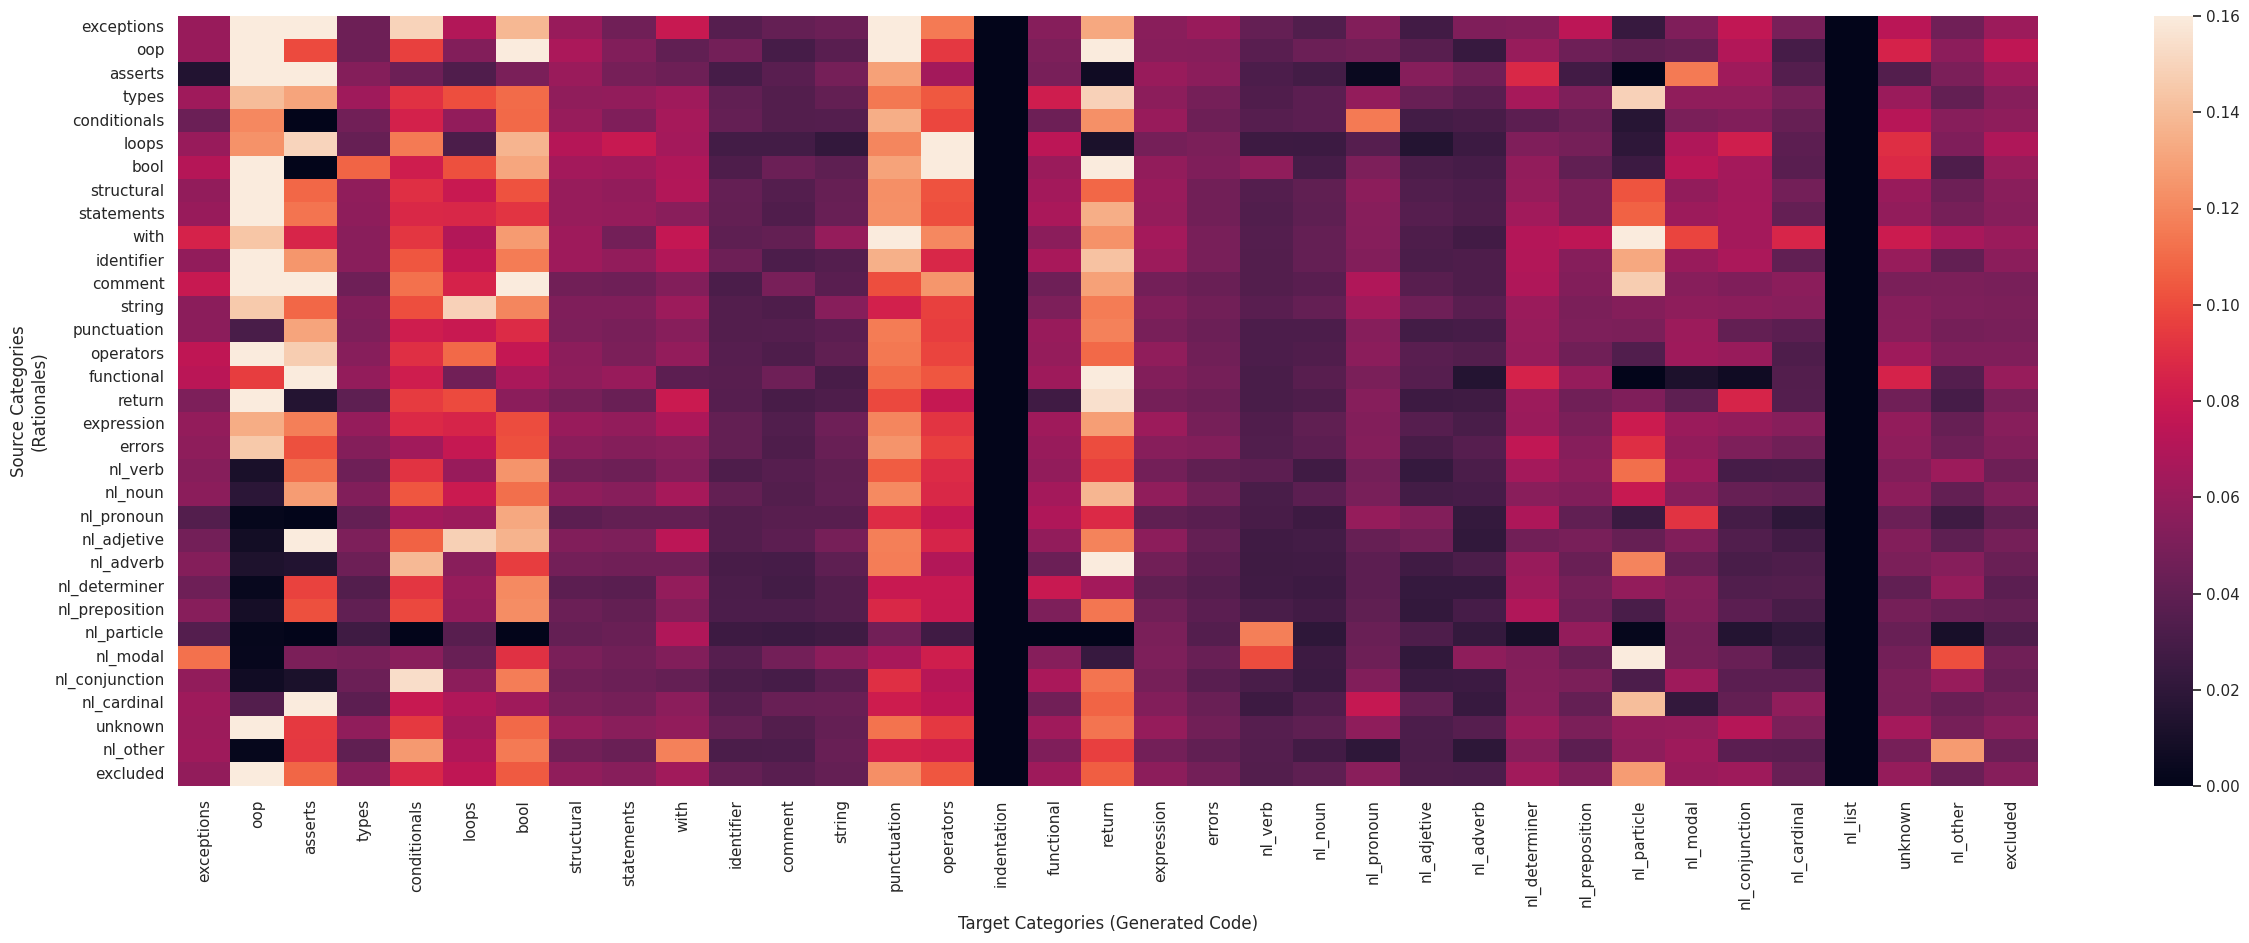

In [50]:
##### TARGET - CATEGORY ALL
##### SOURCE - CATEGORY ALL
target_elements = [category for categories in global_groups().values() for category in categories] #X
source_elements = [category for categories in global_groups().values() for category in categories] #Y
print_heatmap(experiments_global_results, target_list=target_elements, source_list=source_elements, xlabel='Target Categories (Generated Code)', ylabel='Source Categories\n(Rationales)', fig_size=(100,100), vmax=0.16)

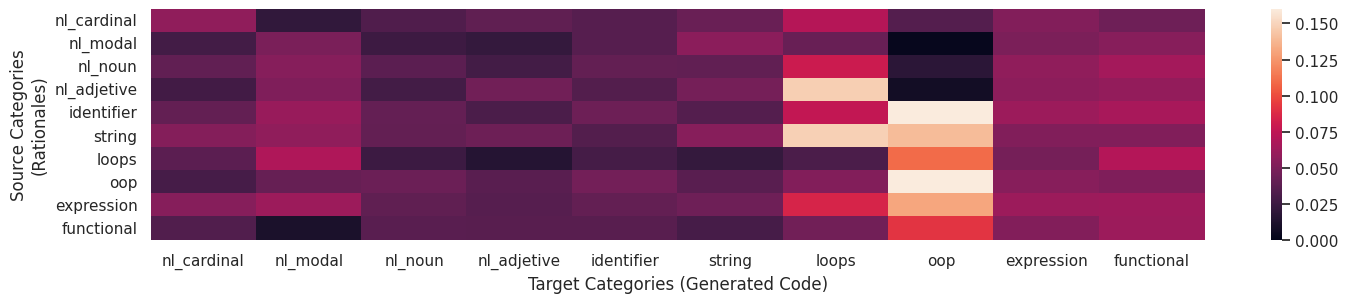

In [117]:
##### TARGET - CATEGORY 
##### SOURCE - CATEGORY
target_elements = ['nl_cardinal', 'nl_modal', 'nl_noun', 'nl_adjetive', 'identifier', 'string', 'loops', 'oop', 'expression', 'functional'] #X
source_elements = ['nl_cardinal', 'nl_modal', 'nl_noun', 'nl_adjetive', 'identifier', 'string', 'loops', 'oop', 'expression', 'functional'] #Y
print_heatmap(experiments_global_results, target_list=target_elements, source_list=source_elements, xlabel='Target Categories (Generated Code)', ylabel='Source Categories\n(Rationales)', fig_size=(17,3), vmax=0.16)

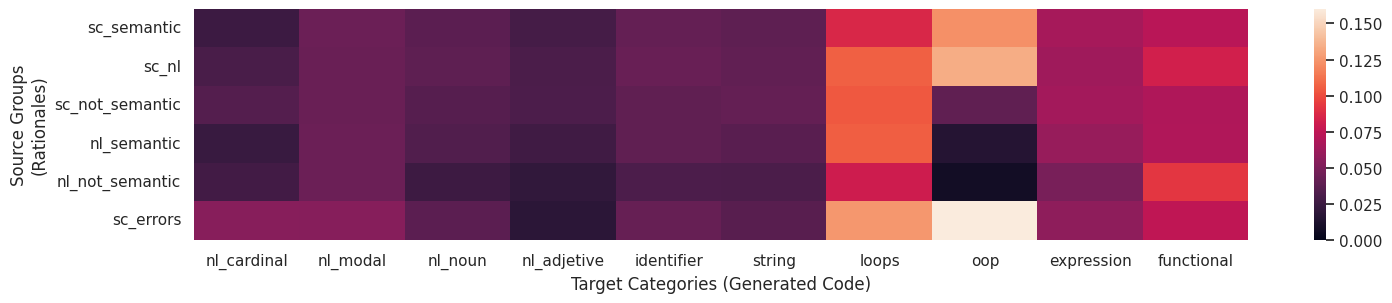

In [118]:
##### TARGET - CATEGORY 
##### SOURCE - GROUP
target_elements = ['nl_cardinal', 'nl_modal', 'nl_noun', 'nl_adjetive', 'identifier', 'string', 'loops', 'oop', 'expression', 'functional'] #X
source_elements = ['sc_semantic', 'sc_nl', 'sc_not_semantic', 'nl_semantic', 'nl_not_semantic', 'sc_errors'] #Y
print_heatmap(global_results_category_by_groups, target_list=target_elements, source_list=source_elements, xlabel='Target Categories (Generated Code)', ylabel='Source Groups\n(Rationales)', fig_size=(17,3), vmax=0.16)

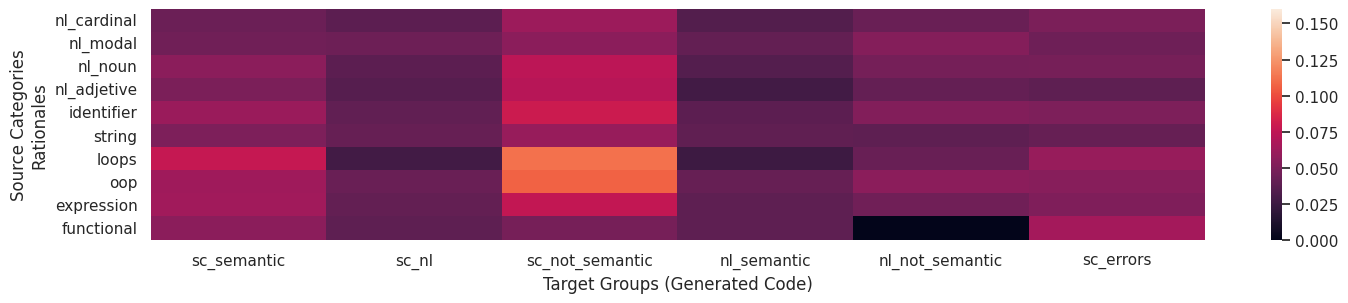

In [119]:
##### TARGET - GROUP 
##### SOURCE - CATEGORY
target_elements = ['sc_semantic', 'sc_nl', 'sc_not_semantic', 'nl_semantic', 'nl_not_semantic', 'sc_errors'] #X
source_elements = ['nl_cardinal', 'nl_modal', 'nl_noun', 'nl_adjetive', 'identifier', 'string', 'loops', 'oop', 'expression', 'functional'] #Y
print_heatmap(global_results_group_by_categories, target_list=target_elements, source_list=source_elements, xlabel='Target Groups (Generated Code)', ylabel='Source Categories\nRationales', fig_size=(17,3), vmax=0.16)

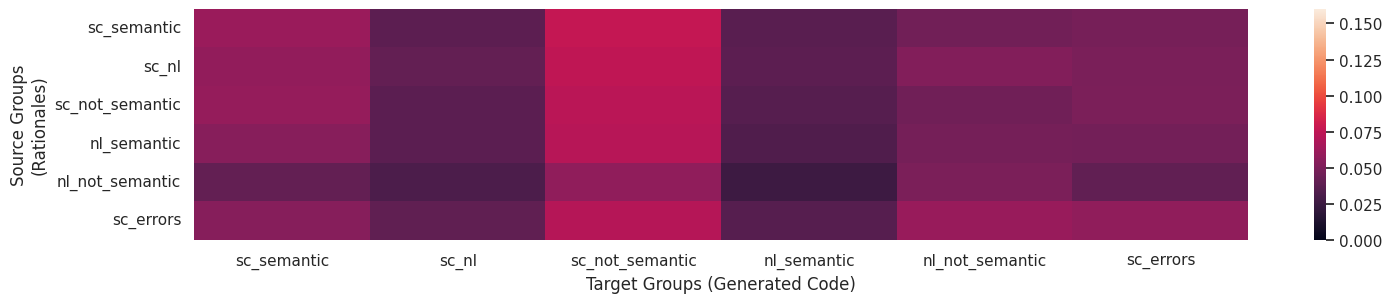

In [120]:
##### TARGET - GROUP 
##### SOURCE - GROUP
target_elements = ['sc_semantic', 'sc_nl', 'sc_not_semantic', 'nl_semantic', 'nl_not_semantic', 'sc_errors'] #X
source_elements = ['sc_semantic', 'sc_nl', 'sc_not_semantic', 'nl_semantic', 'nl_not_semantic', 'sc_errors'] #Y
print_heatmap(global_results_groups_by_groups, target_list=target_elements, source_list=source_elements, xlabel='Target Groups (Generated Code)', ylabel='Source Groups\n(Rationales)', fig_size=(17,3), vmax=0.16)